In [100]:
import pandas as pd
import numpy as np

data1 = pd.read_csv( 'train.csv')

data2 = pd.read_csv( 'comments.csv')

data3 = pd.read_csv( 'comments2.csv')

data = pd.concat( ( data1, data2, data3)).reset_index(drop=True)

import sklearn
data = sklearn.utils.shuffle( data)

data = data.drop_duplicates(subset='comment', keep='first')

X = data[ 'comment']
y = data[ 'label']

In [101]:
from gensim.models import Word2Vec

# Load the Word2Vec model
w2v_model = Word2Vec.load("word2vec-arabic.model")  # Replace with the path to your model if saved


In [102]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42, stratify = y)

<Axes: xlabel='label', ylabel='count'>

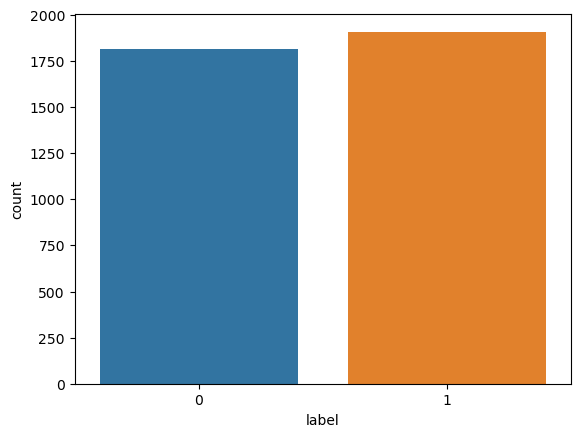

In [103]:
import seaborn as sns

sns.countplot( x=y_train)

In [104]:
# Assuming `your_text_data` is a list of sentences or documents
sentence_lengths = [len( sentence) for sentence in X_train]

# Determine the maximum length based on the 95th percentile, for example
max_length = int(np.percentile(sentence_lengths, 95))

In [136]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts( X_train)

# Convert text to sequences and pad them
train_sequences = tokenizer.texts_to_sequences( X_train)
train_padded_sequences = pad_sequences(train_sequences, maxlen=max_length, padding='post')

# Convert text to sequences and pad them
test_sequences = tokenizer.texts_to_sequences( X_test)
test_padded_sequences = pad_sequences(test_sequences, maxlen=max_length, padding='post')

In [106]:
embedding_dim = 100

In [138]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint

EarlyStopping = EarlyStopping(monitor='val_loss', 
                                patience=6, 
                                restore_best_weights=True)


In [139]:
model_save = ModelCheckpoint('best_model_27_11.keras',
                             save_best_only = True,
                             save_weights_only = False,
                             monitor = 'val_loss',
                             mode = 'min', verbose= 1)

In [140]:
rlr = ReduceLROnPlateau( monitor="val_accuracy",
                            factor=0.01,
                            patience=5,
                            verbose=0,
                            mode="max",
                            min_delta=0.0001)

In [141]:
total_words = len( tokenizer.word_index)



In [142]:
import tensorflow as tf

def create_embedding_matrix(model, word_index, total_words, embedding_dim):
    embedding_matrix = np.zeros((total_words+1, embedding_dim))
    for word, i in word_index.items():
        if word in model.wv and i <= total_words:
            embedding_matrix[i] = model.wv[word]
    return embedding_matrix

embedding_matrix = create_embedding_matrix(w2v_model, tokenizer.word_index, total_words, embedding_dim)

model = tf.keras.Sequential([
        tf.keras.layers.Embedding(total_words+1, embedding_dim, weights=[ embedding_matrix], input_length=max_length, trainable=False),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.50),
        tf.keras.layers.Dense( embedding_dim, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.30),
        tf.keras.layers.Dense(8,activation='relu'),
        tf.keras.layers.Dense(1,activation='sigmoid'),
    ])

model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam( learning_rate=0.0001), metrics = ['accuracy'])

In [143]:
print("Shape of embedding_matrix:", embedding_matrix.shape)

print("Total number of words:", total_words)



Shape of embedding_matrix: (23244, 100)
Total number of words: 23243


In [144]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, 404, 100)          2324400   
                                                                 
 bidirectional_16 (Bidirect  (None, 32)                14976     
 ional)                                                          
                                                                 
 flatten_16 (Flatten)        (None, 32)                0         
                                                                 
 batch_normalization_32 (Ba  (None, 32)                128       
 tchNormalization)                                               
                                                                 
 dropout_32 (Dropout)        (None, 32)                0         
                                                                 
 dense_48 (Dense)            (None, 100)             

In [146]:
from tensorflow.keras.models import load_model


history = model.fit( train_padded_sequences, y_train,
                       validation_split=0.3,
                       epochs = 50,
                       batch_size= 32,
                       callbacks=[ EarlyStopping, model_save, rlr])

Epoch 1/50
82/82 [==============================] - ETA: 0s - loss: 0.5025 - accuracy: 0.7583
Epoch 1: val_loss did not improve from 0.58135
82/82 [==============================] - 14s 119ms/step - loss: 0.5025 - accuracy: 0.7583 - val_loss: 0.5846 - val_accuracy: 0.7075 - lr: 1.0000e-04
Epoch 2/50
82/82 [==============================] - ETA: 0s - loss: 0.5071 - accuracy: 0.7448
Epoch 2: val_loss did not improve from 0.58135
82/82 [==============================] - 9s 105ms/step - loss: 0.5071 - accuracy: 0.7448 - val_loss: 0.5839 - val_accuracy: 0.7120 - lr: 1.0000e-04
Epoch 3/50
82/82 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7609
Epoch 3: val_loss did not improve from 0.58135
82/82 [==============================] - 9s 105ms/step - loss: 0.5006 - accuracy: 0.7609 - val_loss: 0.5834 - val_accuracy: 0.7111 - lr: 1.0000e-04
Epoch 4/50
82/82 [==============================] - ETA: 0s - loss: 0.5004 - accuracy: 0.7609
Epoch 4: val_loss did not improve from

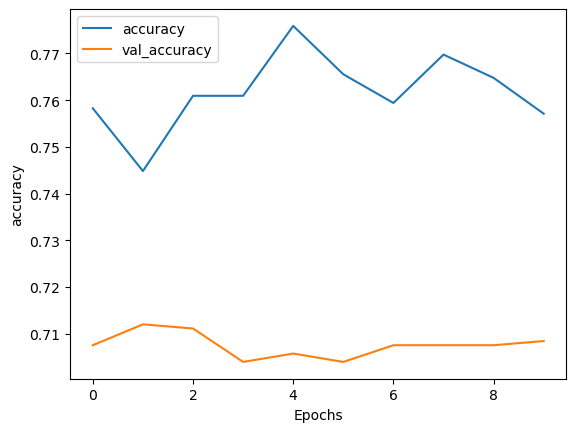

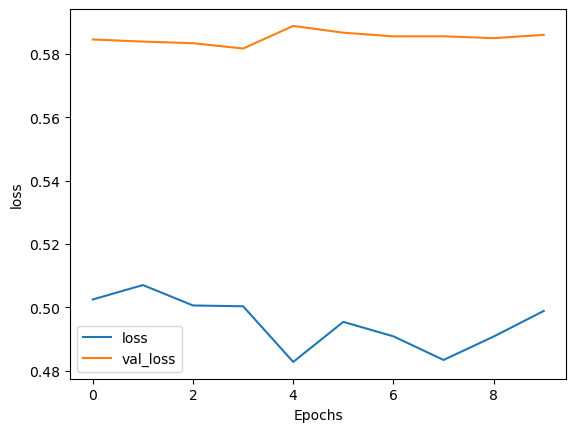

In [147]:
import matplotlib.pyplot as plt

# Plot utility
def plot_graphs(model, string):
    plt.plot(model.history[string])
    plt.plot(model.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

30/30 [==============================] - 1s 31ms/step


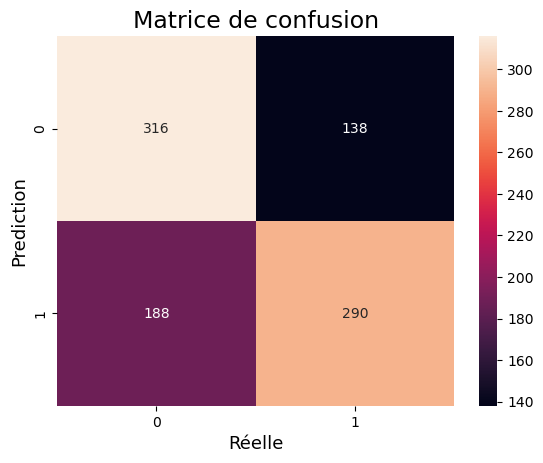

In [137]:
predicted_test = model.predict( test_padded_sequences)
binary_predictions = (predicted_test > 0.5).astype(int)

from sklearn.metrics import confusion_matrix

cm = confusion_matrix( y_test, binary_predictions)

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(cm,
            annot=True,
            fmt='g')
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Réelle',fontsize=13)
plt.title('Matrice de confusion',fontsize=17)
plt.show()